# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 11**

<img src="var_11.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from matplotlib.colors import ListedColormap
import os
from time import perf_counter
from tqdm import trange
from scipy.signal import find_peaks
import imageio

## Model definition

In [2]:
class TimeIt:
    def __enter__(self):
        self.t = perf_counter()
        return self
    
    def __exit__(self, type, value, traceback):
        self.t = perf_counter() - self.t

In [3]:
class HeatProbe:
    """
    Point inside the model which can save its temperature
    """
    def __init__(self, x: int, y: int):
        """
        Keyword arguments:
        x: int - position along x axis
        y: int - position along y axis
        """
        self.x = x
        self.y = y
        self.temperature_history = []
    def write_temperature(self, t:float, T:float) -> None:
        """
        Saves current temperature
        Keyword arguments:
        t: float - time
        T: float - temperature
        """
        self.temperature_history.append([t, T])

In [4]:
class HeatSource:
    """
    Rectangle inside the model which produces heat 
    """
    def __init__(self, x:int, y:int, width:int, height: int, p:float, theta:float):
        """
        Keyword arguments:
        x: int - position along x axis
        y: int - position along y axis
        width: int - length along x axis
        height: int - length along y axis
        p: float - amplitude of power oscillation
        theta: float - period of power oscillation
        """
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.p = p
        self.theta = theta
    def get_power(self, t:float) -> float:
        """
        Calculates power of the source at moment t
        Keyword arguments:
        t: float - point in time
        Returns:
        float - power of the source
        """
        return self.p * (np.sin(2 * np.pi * t / self.theta) + 1)
    def add_heat(self, M: np.ndarray, t: float, dt: float) -> None:
        """
        Adds heat to model
        Keyword arguments:
        M: np.ndarray - matrix of temperatures
        t: float - point in time
        dt: float - time interval
        """
        power = self.get_power(t)
        M[(self.y-self.height):self.y, self.x:(self.x + self.width)] += dt * power      

In [5]:
class HeatTransferModel:
    """
    Class that simulates heat transfer in 2D space
    """
    def __init__(
            self,
            N: int,
            L: int,
            D0: float,
            D1:float,
        ):
        """
        Keyword argumsents:
        N: int - number of points along both axis
        L: int - distance along both axis
        D0: float - diffusion coefficient of main material
        D1: float - diffusion coefficient of included material
        """
        self.N = N
        self.L = L
        self.dx = L/N
        self.D0 = D0
        self.D1 = D1
        self.D = np.full((self.N,self.N), self.D0, dtype=float)
        self.current_state = np.zeros((self.N,self.N), dtype=float)
        self.next_state = np.zeros((self.N,self.N), dtype=float)
        self.heat_sources = []
        self.heat_probes = []

    def add_heat_source(self, x:int, y:int, width:int, height:int, p:float, theta:float) -> None:
        """
        Adds heat source to model
        Keyword arguments:
        x: int - position of the source along x axis
        y: int - position of the source along y axis
        width: int - length of the source along x axis
        height: int - length of the source along y axis
        p: float - amplitude of power oscillation
        theta: float - period of power oscillation
        """
        self.heat_sources.append(HeatSource(x, y, width, height, p, theta))

    def add_heat_probe(self, x: int, y:int) -> None:
        """
        Adds heat probe to model
        Keyword arguments:
        x: int - position of the probe along x axis
        y: int - position of the probe along y axis
        """
        self.heat_probes.append((HeatProbe(x, y)))
    
    def add_inclusion_rect(self, x:int, y:int, width:int, height:int) -> None:
        """
        Adds rectangle made of included material to model
        Keyword arguments:
        x: int - position of the inclusion along x axis
        y: int - position of the inclusion along y axis
        width: int - length of the inclusion along x axis
        height: int - length of the inclusion along y axis
        """
        self.D[y - height: y, x: x + width] = self.D1
    
    def set_permanent_temperature(self, Tx: float, Ty:float):
        """
        sets permanent temperature for x = 0 and y = 0
        Tx: float - temperature along x = 0
        Ty: float - temperature along y = 0
        """
        self.current_state[0, :] = Ty
        self.current_state[:, 0] = Tx
    
    def apply_boundary_conditions(self):
        """
        makes x = N - 1 and y = N - 1 thermal isolated
        """
        self.next_state[:, -1] = self.next_state[:, -2]
        self.next_state[-1, :] = self.next_state[-2, :]
    
    def add_heat_from_sources(self, t):
        """
        Adds heat to the model from all sources
        Keyword arguments:
        t: float - point in time
        """
        for source in self.heat_sources:
            source.add_heat(self.current_state, t, self.dt)
    
    def write_probes_temperature(self, t):
        """
        Writes temperature of all probes
        Keyword arguments:
        t: float - time
        """
        for probe in self.heat_probes:
            probe.write_temperature(t, self.next_state[probe.y, probe.x])
     
    @staticmethod
    @njit(parallel=True)
    def heat_diffusion(N: int, dt: float, dx:float, D:np.ndarray, current_state:np.ndarray, next_state:np.ndarray):
        """
        Calculates heat diffusion via finite-difference method applied to heat differential equation
        Keyword arguments:
        N: int - number of points along both axis
        dt: float - time interval
        dx: float - distance between points in array with neighboring indexes
        D: np.ndarray - array of floats with size (N,N) with corresponding diffusion coefficeints
        current_state: np.ndarray - array of floats with size (N,N) with corresponding heat before diffusion
        next_state: np.ndarray - array of floats with size (N,N) with corresponding heat after diffusion
        """
        for row in prange(1, N-1):
            for column in range(1, N-1):
                g = dt * D[row, column] / dx ** 2
                next_state[row, column] = current_state[row, column] + g * (
                     current_state[row - 1, column] +
                    current_state[row, column - 1] +
                    current_state[row + 1, column] +
                    current_state[row, column + 1] -
                    4 * current_state[row, column]
                )
    def forward(self, iteration: int) -> np.ndarray: 
        """
        Calculates next step of heat transfer model
        Keyword arguments:
        iteration: int - number of iteration
        """
        t = iteration * self.dt
        self.add_heat_from_sources(t)
        HeatTransferModel.heat_diffusion(
                self.N,
                self.dt,
                self.dx,
                self.D,
                self.current_state,
                self.next_state
        )
        self.apply_boundary_conditions()
        self.write_probes_temperature(t)
        self.next_state, self.current_state = self.current_state, self.next_state
        return self.current_state
        
    def simulate(self, t: float, dt: float, directory: str):
        """
        Runs simulation of heat transfer
        Keyword arguments:
        t: float - duratrion of simulation
        dt: float - size of time interval
        directory: str - directory to save files
        """
        self.dt = dt
        n_iter = int(t/dt) + 1
        with TimeIt() as timer:
            for i in trange(n_iter):
                self.forward(i)
        print(f"Time elapsed for N={self.N}, dt={dt} is {timer.t:.3f}s")
        np.save(os.path.join(directory, f"Temperature {self.N}x{self.N}.npy"), self.current_state)
        for ind, probe in enumerate(self.heat_probes):
            np.save(os.path.join(directory,f"Probe{ind} {self.N}x{self.N}.npy"), np.array(probe.temperature_history))
    def show_diffusion_matrix(self):
        """
        Displays diffusion matrix
        """
        plt.figure(figsize=(10,10))
        plt.title("Diffusion matrix")
        ticks = np.arange(0, self.N + 1, self.N//12)
        plt.xticks(ticks)
        plt.yticks(ticks)
        plt.xlabel("x")
        plt.ylabel("y")
        cmap = ListedColormap(["white", "blue"])
        plt.pcolormesh(self.D, cmap = cmap)
        plt.grid(linestyle = '--', linewidth = 1)
        plt.axis('square')
        colorbar = plt.colorbar()
        colorbar.set_ticks(ticks=[self.D1, self.D0],labels=["included_material", "main_material"])
        plt.show()

    def show_model_scheme(self):
        """
        Displays model scheme
        """
        plt.figure(figsize=(10,10))
        plt.title("Heat transfer model scheme")
        plt.xlabel("x")
        plt.ylabel("y")
        ticks = np.arange(0, self.N + 1, self.N//12)
        tick_labels = np.arange(0, self.L + 1, self.L//12)
        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)
        image = np.copy(self.D)
        for source in self.heat_sources:
            image[source.y - source.height: source.y, source.x: source.x + source.width] = 3*self.D0
        cmap = ListedColormap(["white", "blue", "black", "orange"])
        plt.pcolormesh(image, cmap = cmap, zorder=1)
        plt.grid(linestyle = '--', linewidth = 1, zorder=2)
        plt.axis('square')
        colorbar = plt.colorbar()
        colorbar.set_ticks(
            ticks=[self.D1, self.D0, 2*self.D0, 3 * self.D0],
            labels=["included_material", "main_material", "heat_probe", "heat_source"]
        )
        for ind, probe in enumerate(self.heat_probes):
            plt.scatter(probe.y, probe.x, c="black", s=24, zorder=3)
            plt.annotate(ind, (probe.y, probe.x), (probe.y + self.N//self.L,probe.x + self.N//self.L), c="black", fontsize=16)
        plt.show()

    def show_model_temperature(self):
        """
        Displays current temperature matrix
        """
        plt.figure(figsize=(10,10))
        ticks = np.arange(0, self.N + 1, self.N // 12)
        tick_labels = np.arange(0, self.L + 1, self.L // 12)
        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)
        plt.pcolormesh(self.current_state, cmap = "inferno")
        plt.title("Heat map")
        plt.colorbar()
        plt.axis('square')
        plt.show()
    
    def save_temperature_image(self, filepath: str):
        """
        Saves image of current temperature matrix
        Keyword arguments:
        filepath: str - path to image file
        """
        plt.figure(figsize=(10, 10))
        plt.pcolormesh(self.current_state, cmap="inferno")
        plt.axis("off")
        plt.savefig(filepath, bbox_inches="tight")
        plt.close()
    
    def make_gif(self, t: float, dt: float, gif_path: str, directory: str, save_every: int, delete:bool = False):
        """
        Runs simulation and makes gif of temperature diffusion
        Keyword arguments:
        t: float - duratrion of simulation
        dt: float - size of time interval
        gif_path: str - path to resulting gif
        directory: str - directory to save files
        save_every: int - period of image saving
        delete: bool - delete images from which the gif was made
        """
        self.dt = dt
        n_iter = int(t/dt) + 1
        for i in trange(n_iter):
            self.forward(i)
            if i % save_every == 0:
                path_to_file = f"size={self.N}x{self.N},iteration={i}"
                self.save_temperature_image(os.path.join(directory, path_to_file))
        with imageio.get_writer(gif_path, mode='I') as gif_writer:
            for filename in (os.path.join(directory,f"size={self.N}x{self.N},iteration={i}.png") for i in range(0, n_iter, save_every)):
                image = imageio.imread(filename)
                gif_writer.append_data(image)
        if delete:
            for filename in (os.path.join(directory,f"size={self.N}x{self.N},iteration={i}.png") for i in range(0, n_iter, save_every)):
                os.remove(filename)


## Required functions

In [6]:
def create_heat_transfer_model(
    N: int,
):
    """
    Creates heat transfer model according to task scheme
    """
    L = 60
    D0 = 1.0
    D1 = 0.01
    p0 = 100
    theta0 = 43
    p1 = 100
    theta1 = 77
    Tx=Ty=0
    model = HeatTransferModel(N, L, D0, D1)
    model.add_heat_source(N // 12, 2 * N // 3, N // 12, N // 3, p0, theta0)
    model.add_heat_source(N // 3, N // 6, N // 3, N // 12, p1, theta1)
    model.add_heat_probe(N // 3, N // 3)
    model.add_heat_probe(2 * N // 3, N // 3)
    model.add_heat_probe(2 * N // 3, 2 * N // 3)
    model.add_heat_probe(N // 3, 2 * N // 3)
    model.add_inclusion_rect(N // 6, N // 2, N // 12, N // 3)
    model.add_inclusion_rect(N // 4, N // 2, N // 4, N // 12)
    model.add_inclusion_rect(5 * N // 12, 5 * N // 12, N // 12, N // 4)
    model.add_inclusion_rect(N // 3, N // 4, N // 12, N // 12)
    model.set_permanent_temperature(Tx, Ty)
    return model

In [7]:
def show_temperature_from_file(filepath: str, L: int):
    temperature_matrix = np.load(filepath)
    N = temperature_matrix.shape[0]
    plt.figure(figsize=(10,10))
    plt.title("Heat map")
    plt.xlabel("x")
    plt.ylabel("y")
    ticks = np.arange(0, N + 1, N // 12)
    tick_labels = np.arange(0, L + 1, L // 12)
    plt.xticks(ticks, tick_labels)
    plt.yticks(ticks, tick_labels)
    plt.pcolormesh(temperature_matrix, cmap = "inferno", zorder=1)
    plt.colorbar()
    dots_colors = ["red", "green", "blue", "magenta"]
    probes_positions = [(N // 3, N // 3), (2 * N // 3, N // 3), (2 * N // 3, 2 * N // 3), (N // 3,2 * N // 3)]
    for color, probe in zip(dots_colors, enumerate(probes_positions)):
        ind, coordinates = probe
        x, y = coordinates
        plt.scatter(y, x, c=color, s=24, zorder=3)
        plt.annotate(ind, (y, x), (y + N//L,x + N//L), c=color, fontsize=16)

    plt.axis('square')
    plt.show()
    

In [8]:
def plot_probes_data(filepaths: list[str]):
    plt.figure(figsize=(10,10))
    plt.title("Probes heat history")
    plt.xlabel("t")
    plt.ylabel("T")
    probes_data = [np.load(filepath) for filepath in filepaths]
    for ind, probe_data in enumerate(probes_data):
        plt.plot(probe_data[:, 0], probe_data[:, 1], label=f"probe {ind}")
    plt.legend()
    plt.show()


In [9]:
def find_signal_peaks(signal: np.ndarray, dt):
    N = signal.size
    signal_fft = np.fft.rfft(signal - signal.mean())
    amplitude = (np.abs(signal_fft) / (N / 2))[:100]
    signal_frequencies = np.fft.rfftfreq(N, dt)[:100]
    peaks_idx, _ = find_peaks(amplitude)
    return 1 / signal_frequencies[peaks_idx]

In [10]:
def find_probes_heat_periods(filepaths: list[str]):
    
    probes_data = [np.load(filepath) for filepath in filepaths]
    for probe in probes_data:
       trend = np.poly1d(np.polyfit(probe[:, 0], probe[:, 1], 4))(probe[:, 0])
       probe[:, 1] -= trend
    plt.figure(figsize=(10,10))
    plt.title("Probes heat oscillation")
    plt.xlabel("t")
    plt.ylabel("T")
    probes_peaks = []
    for ind, probe in enumerate(probes_data):
        plt.plot(probe[:, 0], probe[:, 1], label=f"probe {ind}")
        dt = probe[1, 0]- probe[0, 0]
        probes_peaks.append(find_signal_peaks(probe[:, 1], dt))
    for ind, probe in enumerate(probes_peaks):
        print(f"Periods of oscillation for probe {ind} are,", ", ".join(map(lambda x: "{:.2f}".format(x),probe)))
    plt.legend()
    plt.show()

## Computatuions

  0%|          | 0/3001 [00:00<?, ?it/s]

100%|██████████| 3001/3001 [00:00<00:00, 3022.82it/s]


Time elapsed for N=60, dt=0.2 is 1.015s


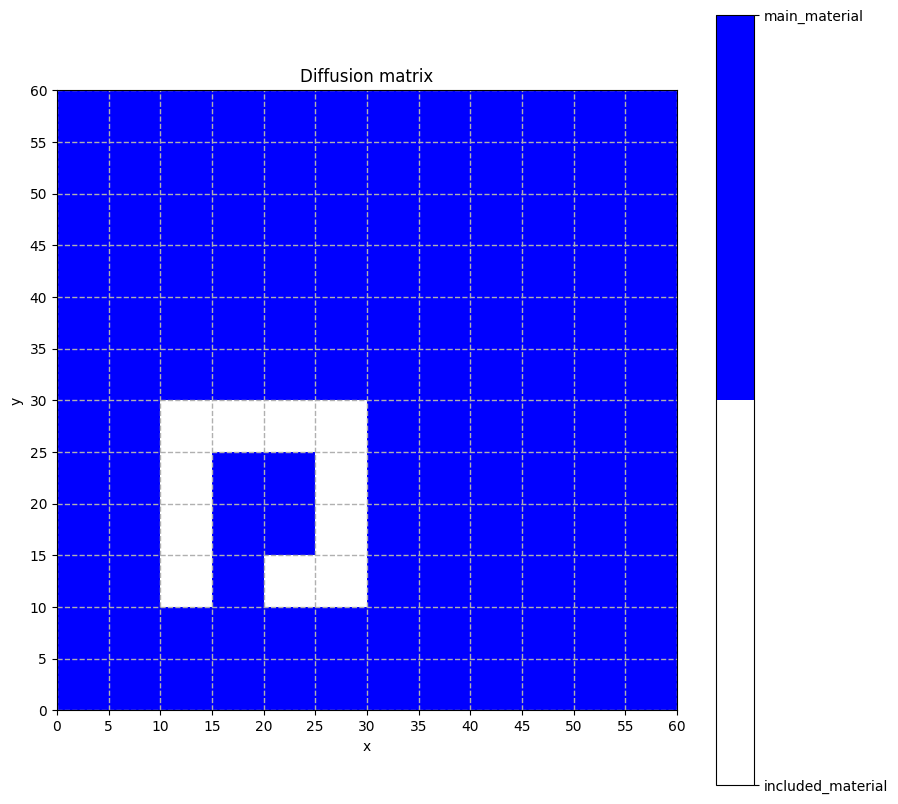

In [11]:
dt = 0.2
N = 60
t=600
model_tiny = create_heat_transfer_model(N)
model_tiny.simulate(t, dt, "files/")
model_tiny.show_diffusion_matrix()

#### Example of show model scheme 

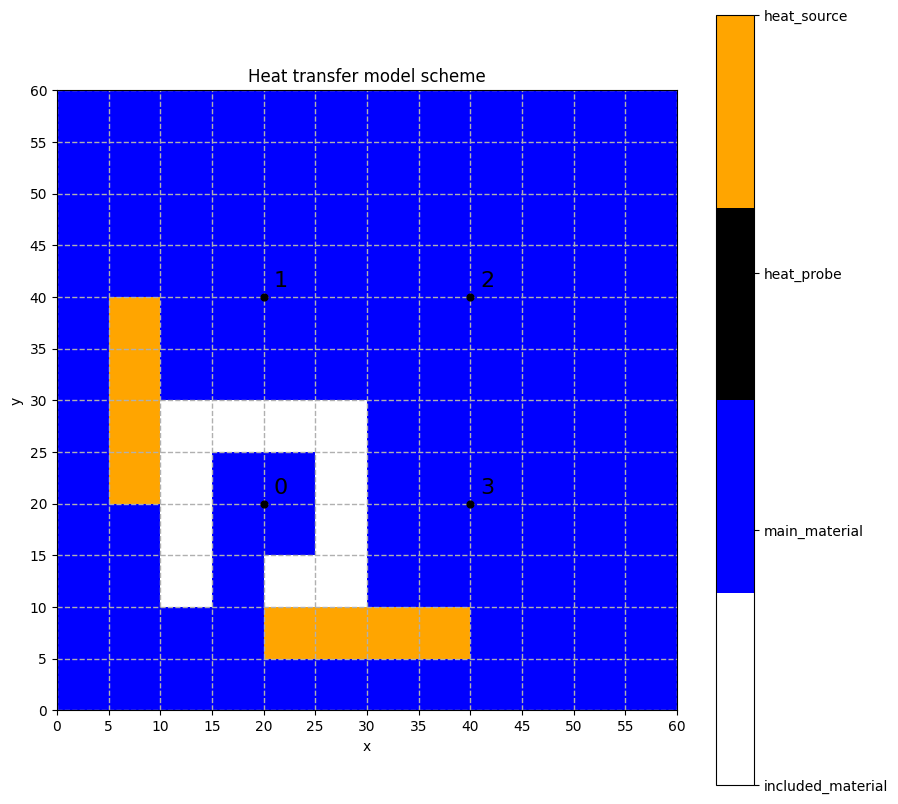

In [12]:
model_tiny.show_model_scheme()

100%|██████████| 60001/60001 [00:02<00:00, 29153.20it/s]


Time elapsed for N=120, dt=0.01 is 2.059s


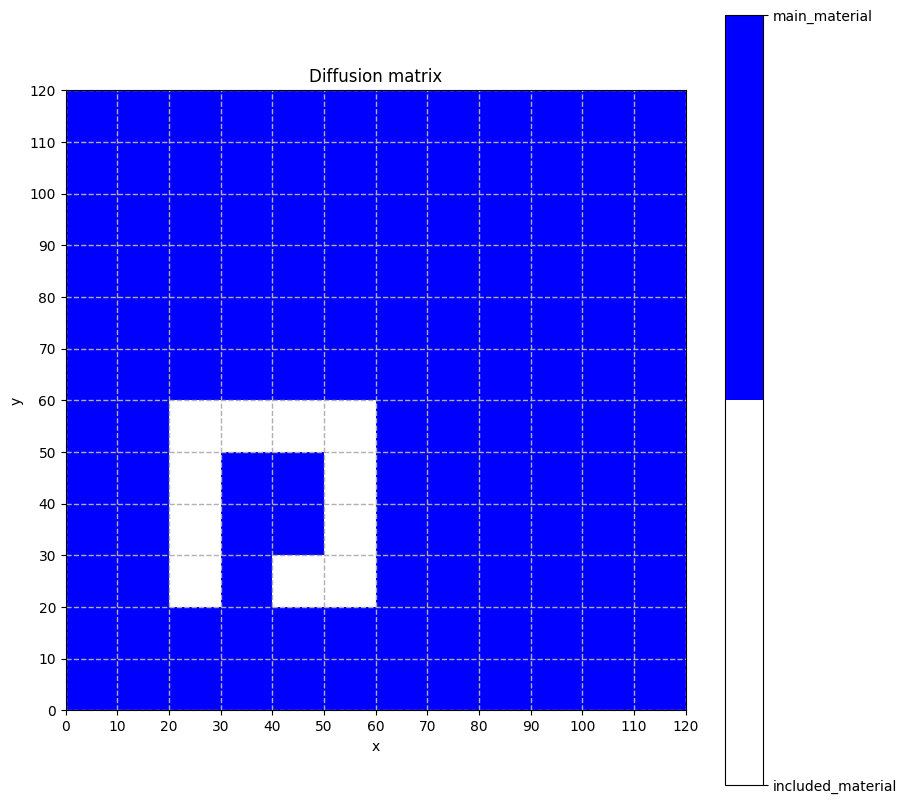

In [13]:
dt = 0.01
N = 120
t = 600
model_small = create_heat_transfer_model(N)
model_small.simulate(t, dt, "files/")
model_small.show_diffusion_matrix()

100%|██████████| 120001/120001 [00:04<00:00, 24310.33it/s]


Time elapsed for N=240, dt=0.005 is 4.937s


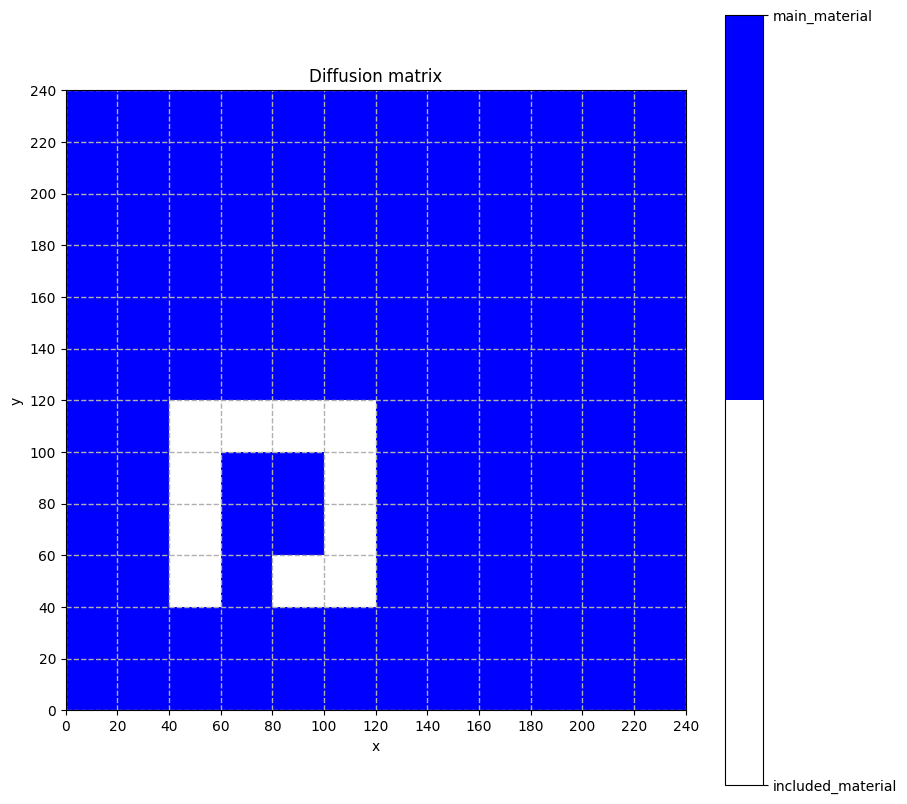

In [14]:
dt = 0.005
N = 240
t = 600
model_base = create_heat_transfer_model(N)
model_base.simulate(t, dt, "files/")
model_base.show_diffusion_matrix()

100%|██████████| 300001/300001 [00:21<00:00, 14207.10it/s]


Time elapsed for N=480, dt=0.002 is 21.118s


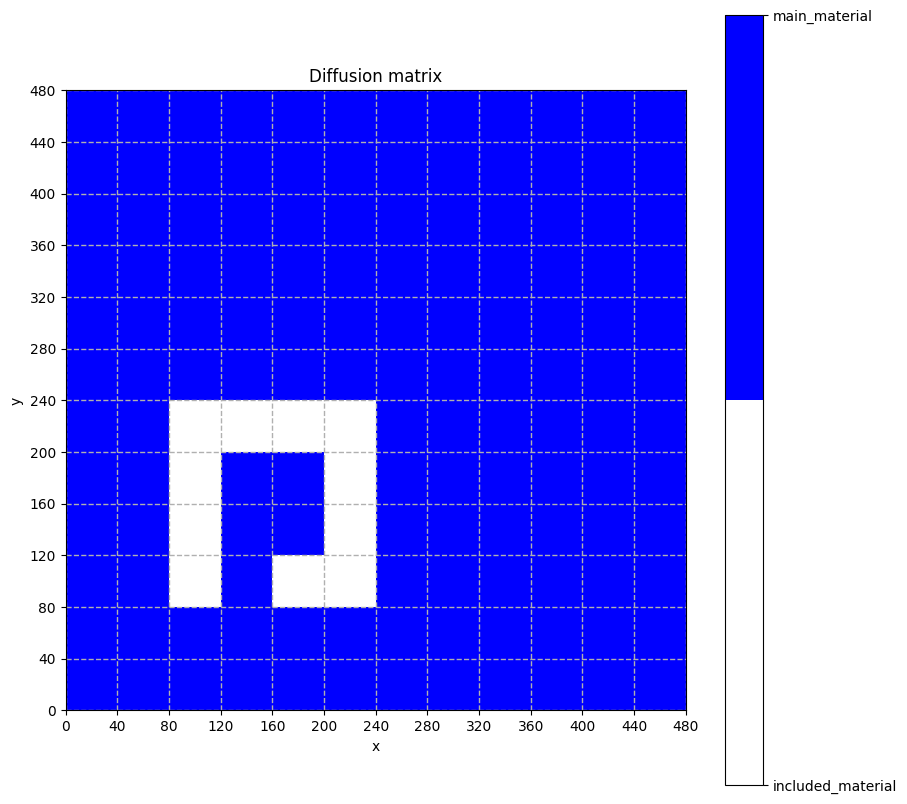

In [15]:
dt = 0.002
N = 480
t=600
model_large = create_heat_transfer_model(N)
model_large.simulate(t, dt, "files/")
model_large.show_diffusion_matrix()

100%|██████████| 1200001/1200001 [04:11<00:00, 4778.71it/s]


Time elapsed for N=960, dt=0.0005 is 251.115s


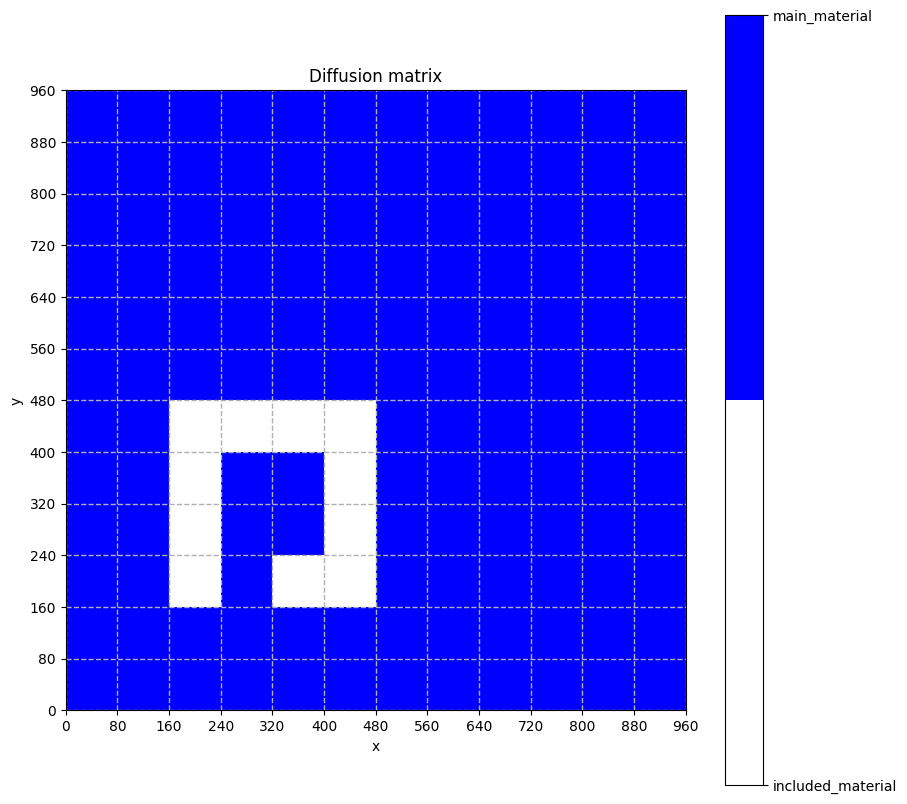

In [16]:
dt = 0.0005
N = 960
t=600
model_xlarge = create_heat_transfer_model(N)
model_xlarge.simulate(t, dt, "files/")
model_xlarge.show_diffusion_matrix()

## Making a gif

In [17]:
dt = 0.002
N = 240
t = 600
save_every = 500
model_for_gif = create_heat_transfer_model(N)
model_for_gif.make_gif(t, dt, "heat_transfer.gif", "images", 500, True)

100%|██████████| 300001/300001 [00:52<00:00, 5706.76it/s]
C:\Users\igmir\AppData\Local\Temp\ipykernel_6668\2863342751.py:253: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Data processing

In [18]:
L = 60

### Tiny (60 X 60)

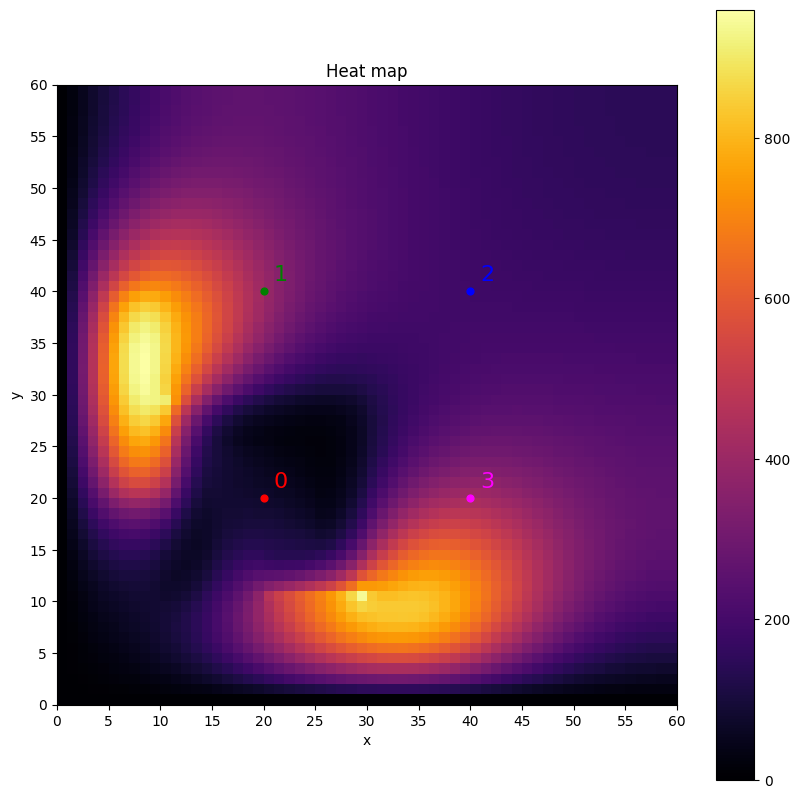

In [19]:
show_temperature_from_file("files/Temperature 60x60.npy", L)

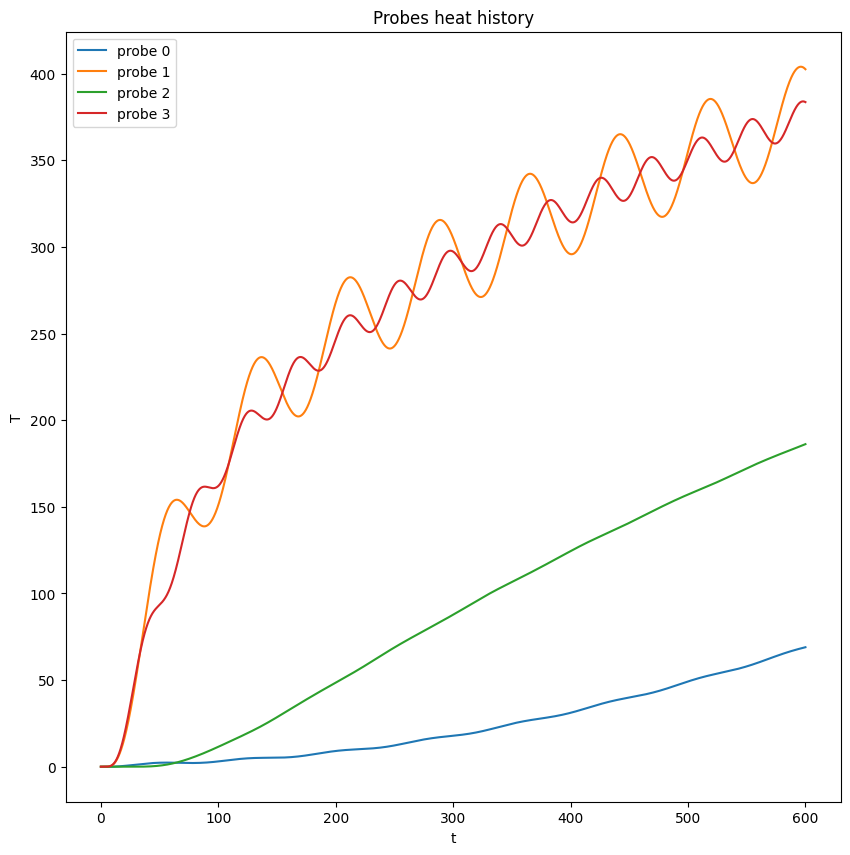

In [20]:
probes = [f"files/Probe{i} 60x60.npy" for i in range(4)]
plot_probes_data(probes)

Periods of oscillation for probe 0 are, 300.10, 75.03
Periods of oscillation for probe 1 are, 300.10, 75.03
Periods of oscillation for probe 2 are, 300.10, 150.05, 75.03, 40.01
Periods of oscillation for probe 3 are, 300.10, 120.04, 42.87


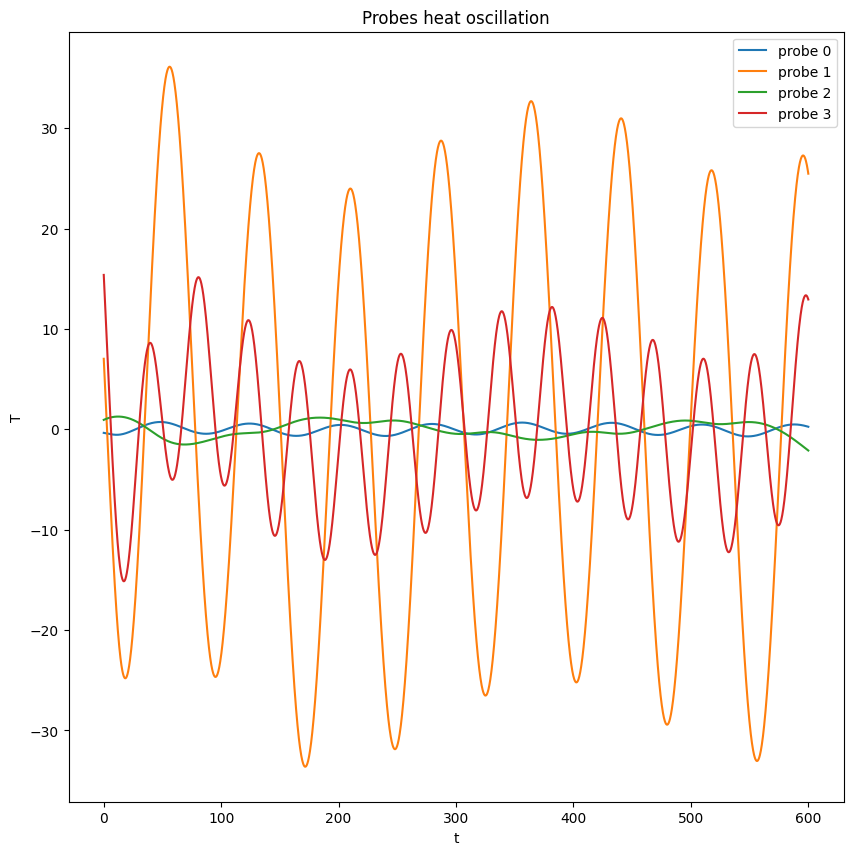

In [21]:
find_probes_heat_periods(probes)

### Small (120 X 120)

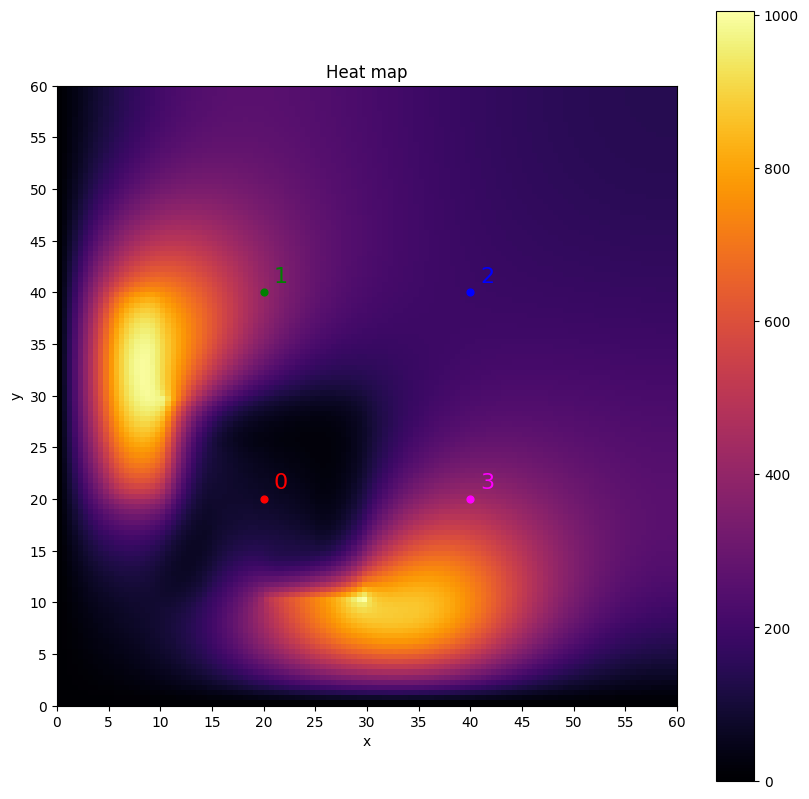

In [22]:
show_temperature_from_file("files/Temperature 120x120.npy", L)

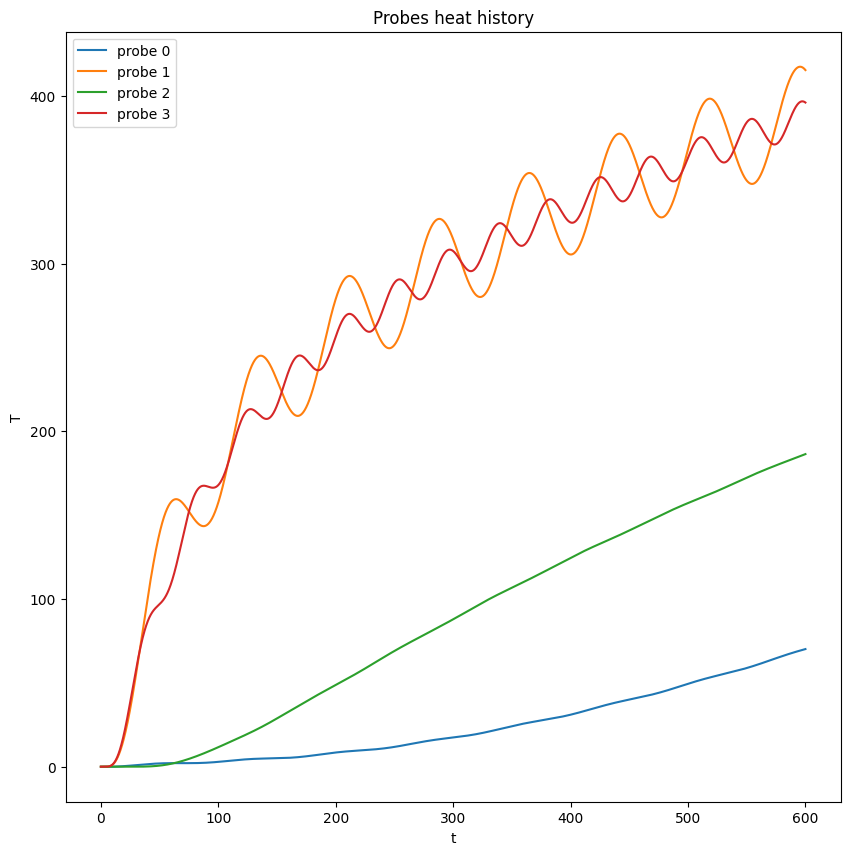

In [23]:
probes = [f"files/Probe{i} 120x120.npy" for i in range(4)]
plot_probes_data(probes)

Periods of oscillation for probe 0 are, 300.00, 75.00
Periods of oscillation for probe 1 are, 300.00, 75.00
Periods of oscillation for probe 2 are, 300.00, 150.00, 75.00, 40.00
Periods of oscillation for probe 3 are, 300.00, 120.00, 42.86


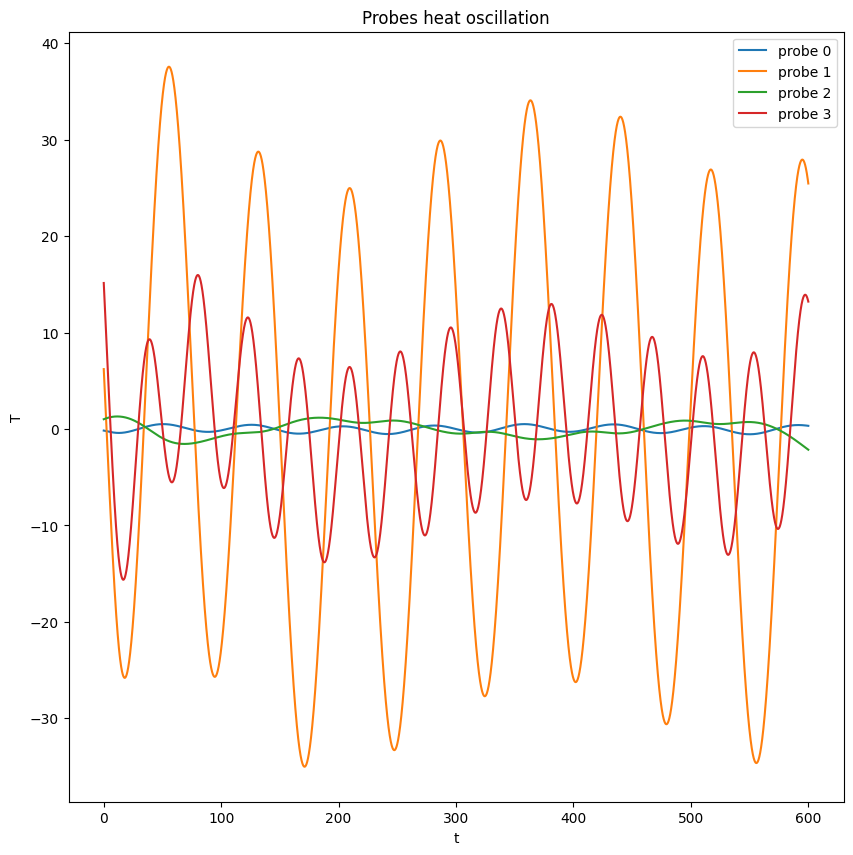

In [24]:
find_probes_heat_periods(probes)

### Medium (240 X 240)

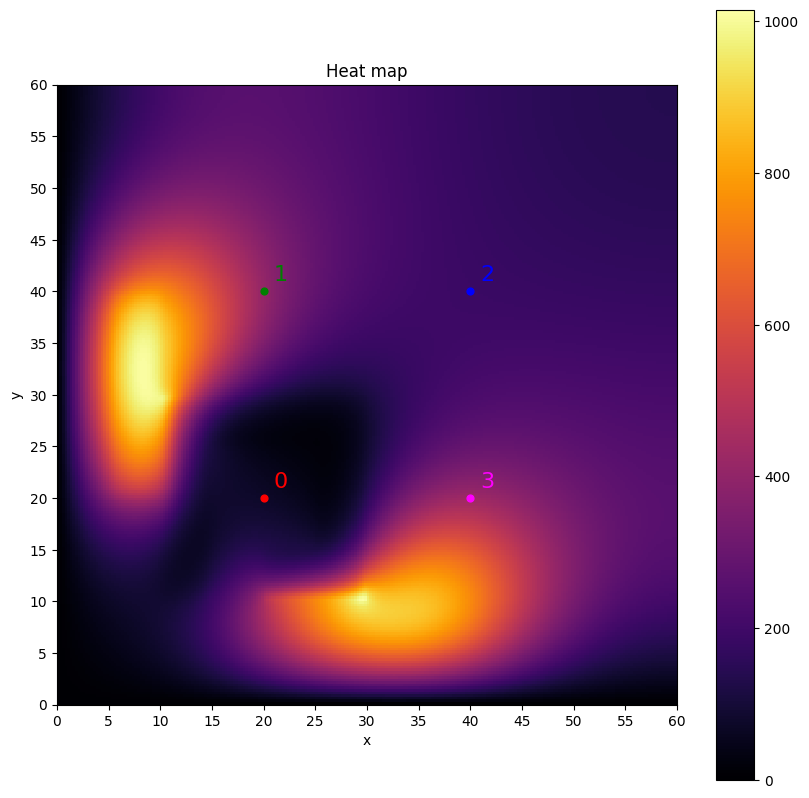

In [25]:
show_temperature_from_file("files/Temperature 240x240.npy", L)

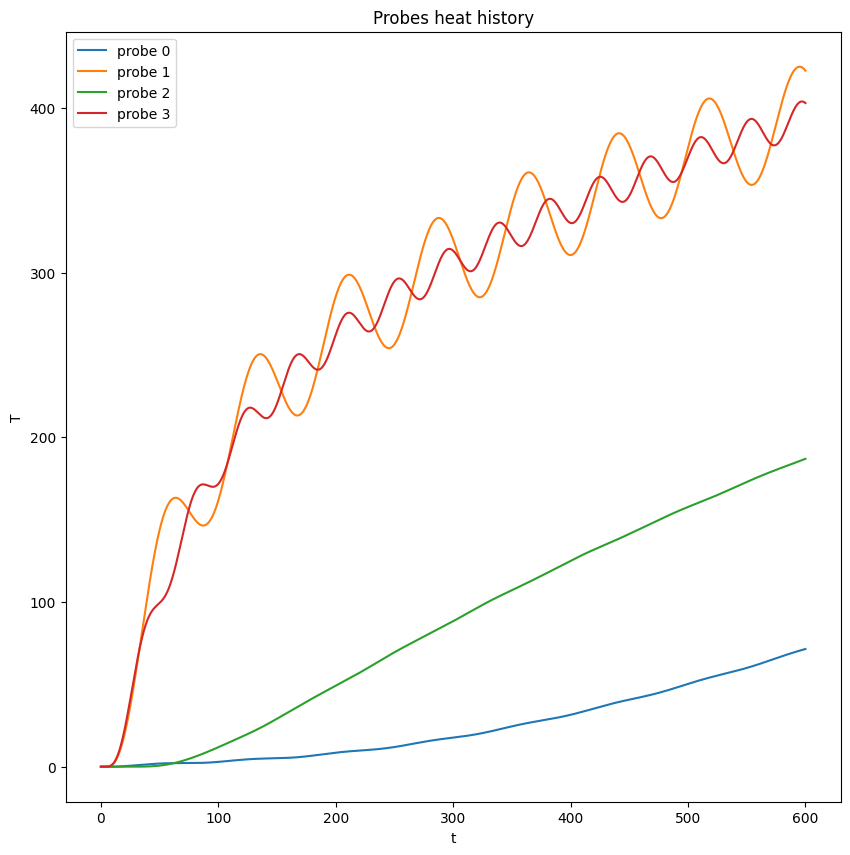

In [26]:
probes = [f"files/Probe{i} 240x240.npy" for i in range(4)]
plot_probes_data(probes)

Periods of oscillation for probe 0 are, 300.00, 75.00
Periods of oscillation for probe 1 are, 300.00, 75.00
Periods of oscillation for probe 2 are, 300.00, 150.00, 75.00, 40.00
Periods of oscillation for probe 3 are, 300.00, 120.00, 42.86


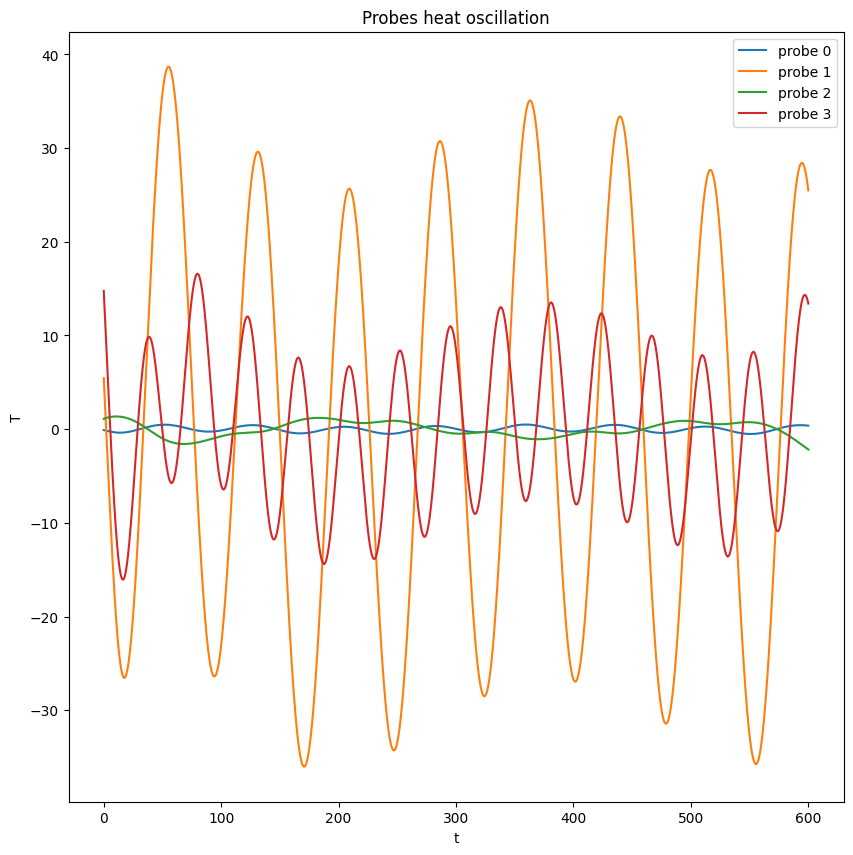

In [27]:
find_probes_heat_periods(probes)

### Large (480 X 480)

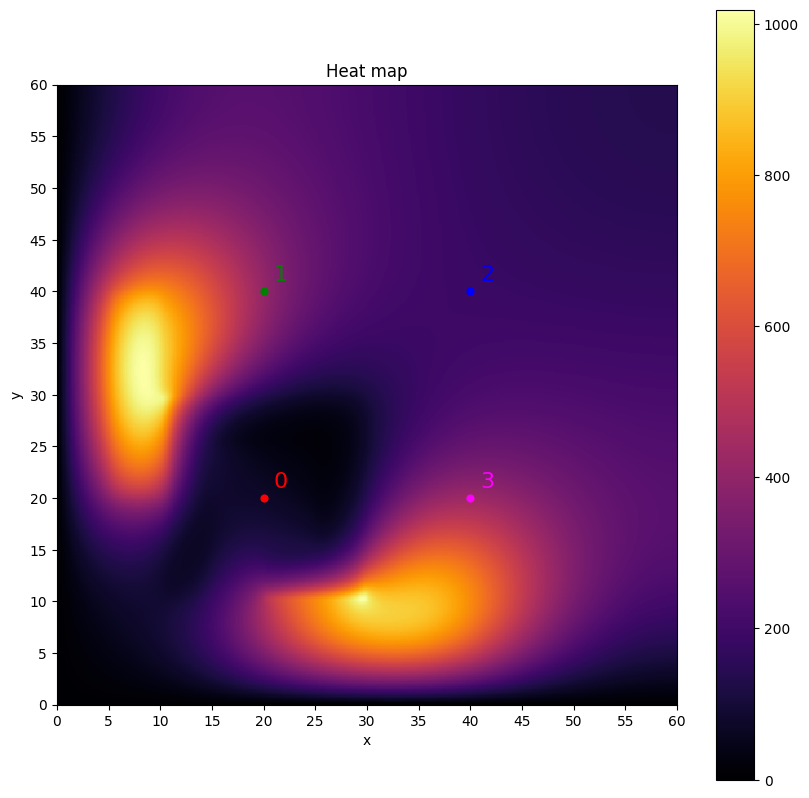

In [28]:
show_temperature_from_file("files/Temperature 480x480.npy", L)

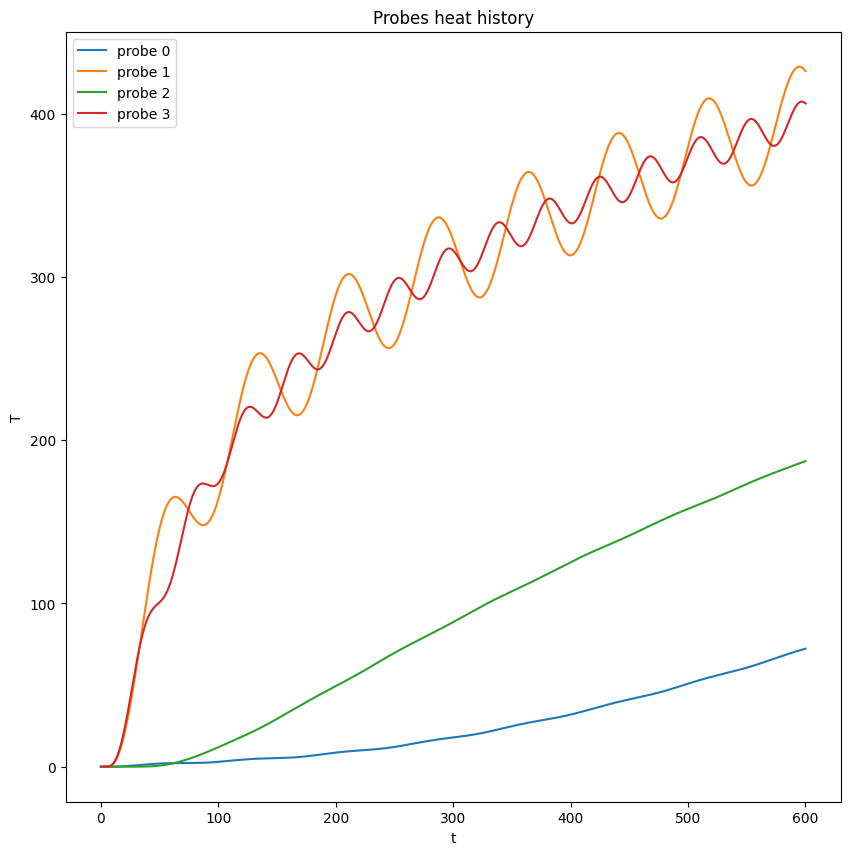

In [29]:
probes = [f"files/Probe{i} 480x480.npy" for i in range(4)]
plot_probes_data(probes)

Periods of oscillation for probe 0 are, 300.00, 75.00
Periods of oscillation for probe 1 are, 300.00, 75.00
Periods of oscillation for probe 2 are, 300.00, 150.00, 75.00, 40.00
Periods of oscillation for probe 3 are, 300.00, 120.00, 42.86


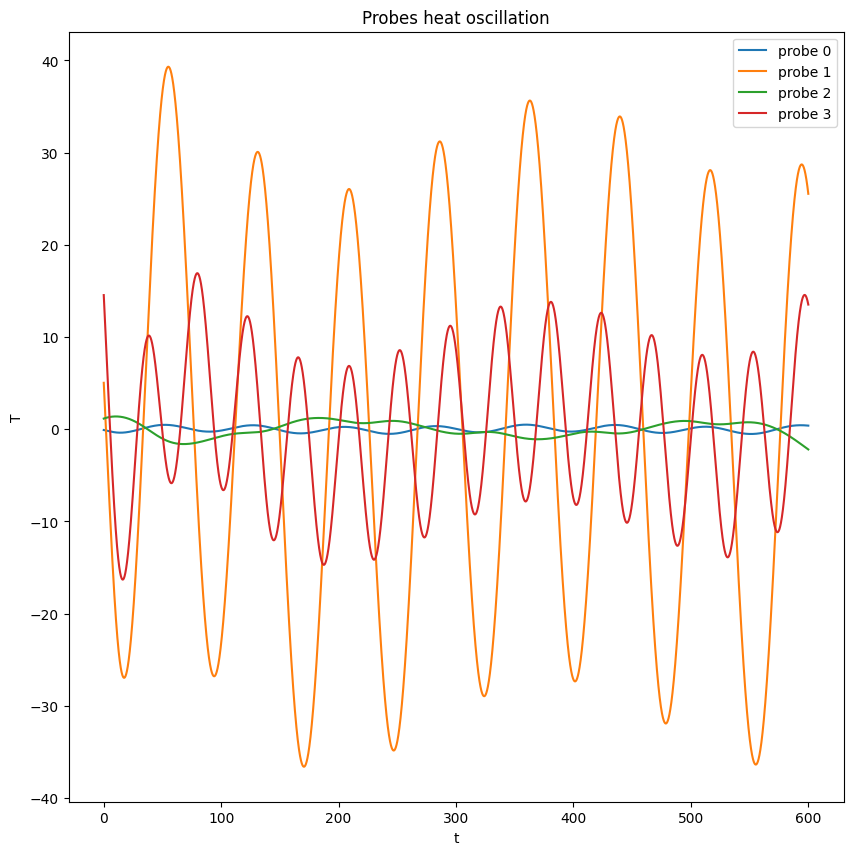

In [30]:
find_probes_heat_periods(probes)

### XLarge (960 X 960)

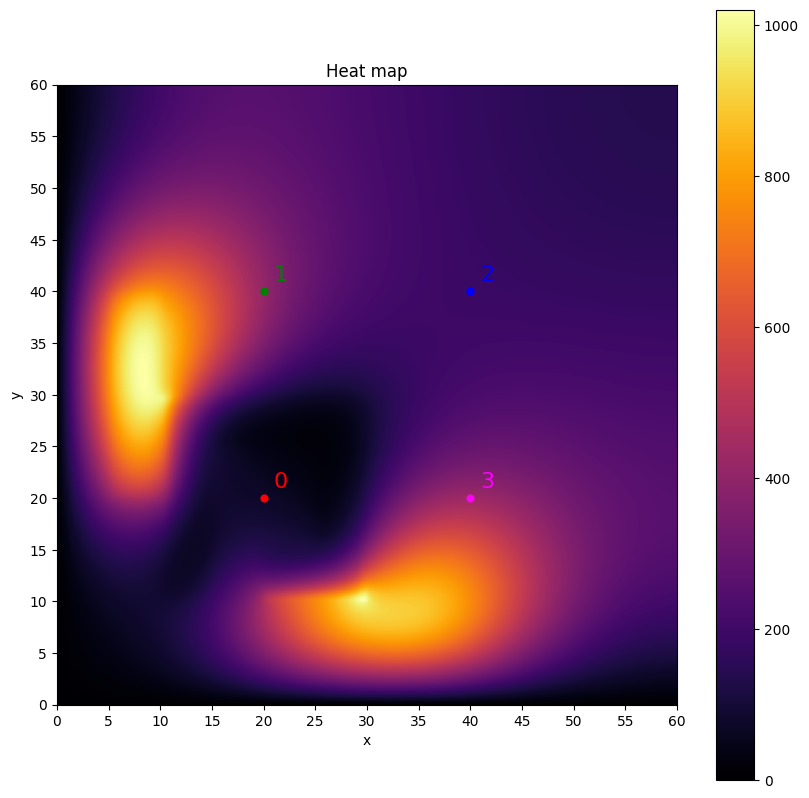

In [31]:
show_temperature_from_file("files/Temperature 960x960.npy", L)

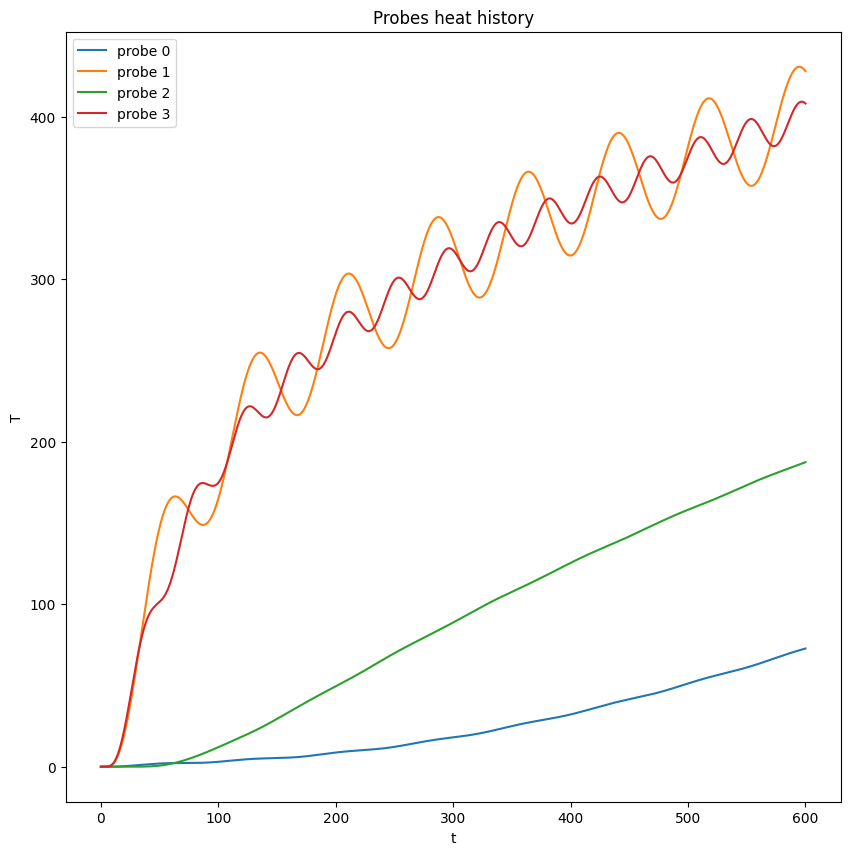

In [32]:
probes = [f"files/Probe{i} 960x960.npy" for i in range(4)]
plot_probes_data(probes)

Periods of oscillation for probe 0 are, 300.00, 75.00
Periods of oscillation for probe 1 are, 300.00, 75.00
Periods of oscillation for probe 2 are, 300.00, 150.00, 75.00, 40.00
Periods of oscillation for probe 3 are, 300.00, 120.00, 42.86


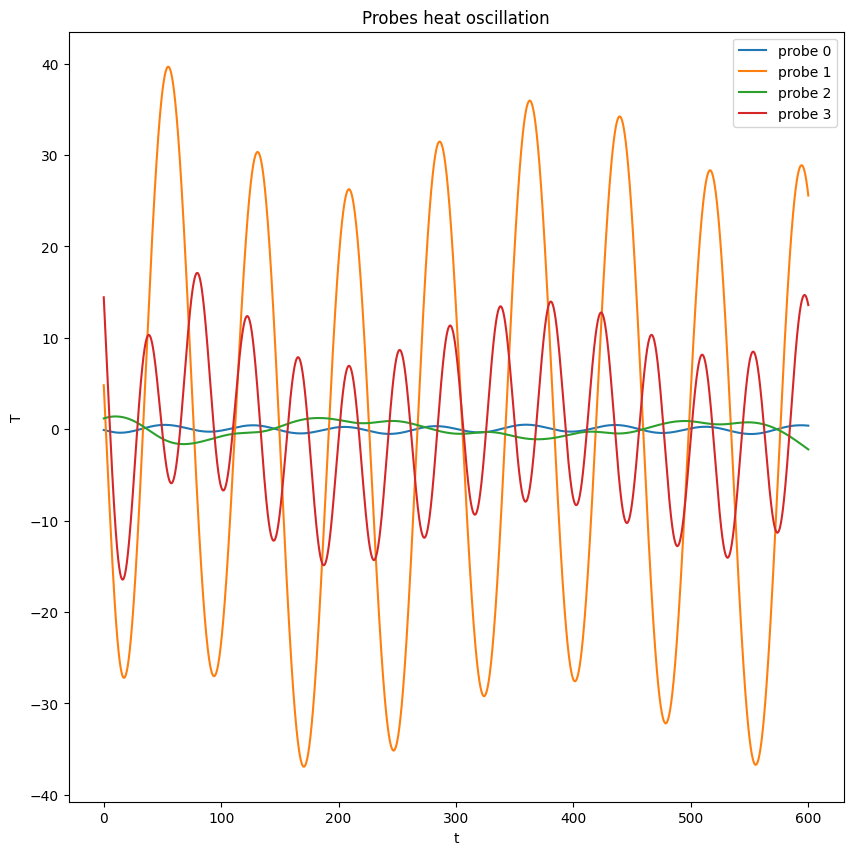

In [33]:
find_probes_heat_periods(probes)